<a href="https://colab.research.google.com/github/eyupdalan/BLM6114-hw1/blob/main/BLM6114hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python
!pip install datasets

In [2]:
import random
import torch
import pandas as pd
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from enum import Enum

## Verilerin alınması
https://huggingface.co/datasets/ytu-ce-cosmos/gsm8k_tr adresinde
bulunan dosyadaki question ları soru, answer ları cevap olarak kullanınız.
Bu dosyadan rasgele 1000 soru ve o sorunun cevabı 2’lisi seçiniz.

#### Verileri okuma

In [3]:
all_data = pd.read_csv("hf://datasets/ytu-ce-cosmos/gsm8k_tr/gsm8k_tr.csv")

#file_path = "/content/sample_data/gsm8k_tr.csv"
#all_data = pd.read_csv(file_path)

print(all_data.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                            question  \
0  Borris tekel bayisi her 6 ayda bir 90 kilogram...   
1  Mel, Katherine'den üç yaş küçük.  Katherine ik...   
2  James 2 ağacındaki tüm meyveleri toplar.  Her ...   
3  Kyle, her biri 15 origami yıldızı alabilen 2 c...   
4  Mark'ın iki evcil hayvanı var: Saniyede 10 adı...   

                                              answer  
0  Borris şu anda her 6 ayda 90 kilogram üzüm kul...  
1  Katherine iki düzine yaşına geldiğinde 24 yaşı...  
2                           James 24 ağaç dikmiştir.  
3  Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...  
4  Kaplumbağanın yarışı berabere bitirmesi için 1...  


#### Rasgele 1000 datanın alınması

In [4]:
sample_count = 1000 #1000
total_data_length = len(all_data)
print("Total data length: ", total_data_length)

random.seed(111)
randomly_selected_indices = random.sample(range(total_data_length), sample_count) #randomly select 1000 samples

data = all_data.iloc[randomly_selected_indices].reset_index(drop=True)

print(data.head())


Total data length:  8792
                                            question  \
0  Bayan Thompson tanesi 3 dolardan 3 tavuk aldı....   
1  Bir bekleme odasında yirmi iki kişi bulunmakta...   
2  Elise babasının 250 kitaptan oluşan koleksiyon...   
3  Beyaz tavşan bir dakikada 15 metre zıplayabili...   
4  Grubun konserine 500 kişi katıldı. Bu konser i...   

                                              answer  
0                      Patatesler 6 dolara mal oldu.  
1                 Görüşme odasında dört kişi vardır.  
2  Elise'nin babasının 250 kitaplık koleksiyonund...  
3  Beyaz tavşanın 5 dakikada zıplayacağı mesafe: ...  
4  Her bilet 30$ ve grup bilet fiyatının %70'ini ...  


#### Seçilen modeller
https://huggingface.co/spaces/mteb/leaderboard adresinde ilk 100’e girmiş, multilingual olan ve 1 milyar parametreden küçük olan 5 model

#### Tokenizer işlemleri

In [5]:
selected_models = [
    "intfloat/multilingual-e5-large-instruct",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "HIT-TMG/KaLM-embedding-multilingual-mini-v1",
    "jinaai/jina-embeddings-v3",
    #"Lajavaness/bilingual-embedding-large", # Türkçe yok!!
    "BAAI/bge-m3"
]
compare_model = "ytu-ce-cosmos/turkish-colbert"
all_models = selected_models + [compare_model]

print("All models: ", all_models)

def average_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

def create_model_embeddings(model_name, input_text, batch_size):
    embeddings_list = []

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

    # Tek seferde embedding hesaplaması çok fazla memory tüketimine sebep olup
    # crash olmasına sebep oluyordu. o yüzden burada batch_size'a göre parçalı
    # parçalı hesaplanması sağlandı
    for i in range(0, len(input_text), batch_size):
        batch = input_text[i : i + batch_size]
        with torch.no_grad():
            batch_dict = tokenizer(batch, max_length=128, padding=True, truncation=True, return_tensors="pt")
            batch_dict = {k: v.to(model.device) for k, v in batch_dict.items()}
            outputs = model(**batch_dict)
        embeddings = average_pool(outputs.last_hidden_state, batch_dict["attention_mask"])
        embeddings = F.normalize(embeddings, p=2, dim=1)
        embeddings_list.append(embeddings)

    # Tüm embedding'leri birleştir
    return torch.cat(embeddings_list, dim=0)


All models:  ['intfloat/multilingual-e5-large-instruct', 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2', 'HIT-TMG/KaLM-embedding-multilingual-mini-v1', 'jinaai/jina-embeddings-v3', 'BAAI/bge-m3', 'ytu-ce-cosmos/turkish-colbert']


In [6]:
class Type(Enum):
  ANSWERS = "answers"
  QUESTIONS = "questions"

batch_size = 1024  # Her batch'te işlenecek metin sayısı

questions_text = data['question'].tolist()
answers_text = data['answer'].tolist()

model_embeddings_list = {}

for model_name in all_models:
    print(f"Model: {model_name}")

    question_embeddings = create_model_embeddings(model_name, questions_text, batch_size=batch_size)
    answer_embeddings = create_model_embeddings(model_name, answers_text, batch_size=batch_size)

    model_embeddings_list[model_name] = {
        Type.QUESTIONS: question_embeddings,
        Type.ANSWERS: answer_embeddings
    }
    print(f"{model_name} embedding created")

print("All embeddings created", model_embeddings_list)


Model: intfloat/multilingual-e5-large-instruct
intfloat/multilingual-e5-large-instruct embedding created
Model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
sentence-transformers/paraphrase-multilingual-mpnet-base-v2 embedding created
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1


Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


HIT-TMG/KaLM-embedding-multilingual-mini-v1 embedding created
Model: jinaai/jina-embeddings-v3
jinaai/jina-embeddings-v3 embedding created
Model: BAAI/bge-m3
BAAI/bge-m3 embedding created
Model: ytu-ce-cosmos/turkish-colbert
ytu-ce-cosmos/turkish-colbert embedding created
All embeddings created {'intfloat/multilingual-e5-large-instruct': {<Type.QUESTIONS: 'questions'>: tensor([[ 0.0209,  0.0050, -0.0376,  ..., -0.0453, -0.0612,  0.0097],
        [ 0.0171,  0.0103, -0.0421,  ..., -0.0458, -0.0338,  0.0402],
        [ 0.0060,  0.0083, -0.0304,  ..., -0.0306, -0.0517,  0.0340],
        ...,
        [ 0.0230,  0.0041, -0.0480,  ..., -0.0193, -0.0522,  0.0265],
        [ 0.0069,  0.0024, -0.0320,  ..., -0.0592, -0.0515,  0.0153],
        [-0.0060,  0.0166, -0.0378,  ..., -0.0472, -0.0371,  0.0280]]), <Type.ANSWERS: 'answers'>: tensor([[ 0.0208,  0.0143,  0.0043,  ..., -0.0237, -0.0274,  0.0255],
        [ 0.0321,  0.0276, -0.0135,  ..., -0.0354, -0.0332,  0.0268],
        [ 0.0321,  0.0085,

#### Arama ve top1 top5 baraşarılarını hesaplama fonksiyonları

In [7]:
def find_most_similar_indices(type: Type, embeddings: torch.Tensor, query_idx: int, top_k: int = 5):
    query = embeddings[type][query_idx].unsqueeze(0)
    context_embedding_type = Type.ANSWERS if type == Type.QUESTIONS else Type.QUESTIONS
    context_embeddings = embeddings[context_embedding_type]
    similarity = F.cosine_similarity(query, context_embeddings, dim=1)

    top_k_values, top_k_indices = torch.topk(similarity, top_k)
    # Tensor'ları Python listesine dönüştür
    top_k_indices = top_k_indices.tolist()

    # Sadece top_k sonucu al
    top_k_scores = [similarity[idx].item() for idx in top_k_indices]

    return top_k_indices, top_k_scores

def search_from_embedding(type: Type, embeddings: torch.Tensor, query_idx: int, top_k: int = 5):
    top_k_indices, top_k_scores = find_most_similar_indices(type, embeddings, query_idx, top_k)

    if(type == Type.ANSWERS):
      top_k_results = [questions_text[idx] for idx in top_k_indices]
    else:
      top_k_results = [answers_text[idx] for idx in top_k_indices]

    #print(f"Sorgu: {answers_text[query_idx]}")
    #for i, (result, score) in enumerate(zip(top_k_results, top_k_scores)):
    #    print(f"{i+1}. Benzerlik: {score:.4f}, Metin: {result}")

    return top_k_results, top_k_scores, top_k_indices

def calculate_accuracy(type: Type, embeddings: torch.Tensor, top_k: int = 5):
    total_correct = 0
    total_queries = len(data)

    for query_idx in range(total_queries):
        top_k_results, top_k_scores, top_k_indices = search_from_embedding(type,embeddings, query_idx, top_k)

        # sorunun index'i ile doğru cevabının index'i aynı
        if(query_idx in top_k_indices):
            total_correct += 1

    accuracy = total_correct / total_queries
    return accuracy

#

#### Top-5 ve top-1 sonuçları için grafik çizimi

In [10]:
import matplotlib.pyplot as plt

def draw_results(model_results):
  fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and axes object
  bars = ax.bar(model_results["models"], model_results["accuracy"], color='skyblue')  # Create the bars and store them
  ax.bar_label(bars, fmt='%.3f', label_type='edge')  # Add labels to the bars with 3 decimal places, positioned at the edge
  ax.set_title('Sonuçlar')  # Grafik başlığını ekle
  ax.set_xlabel('Modeller')  # X eksenini etiketle
  ax.set_ylabel('Başarı')  # Y eksenini etiketle
  ax.set_ylim(0, 1)  # Y ekseninin sınırlarını ayarla
  plt.xticks(rotation=45, ha='right')  # X ekseni etiketlerini döndür
  fig.tight_layout()  # Grafik düzenini iyileştir
  plt.show()  # Grafiği göster


#### Cevaplar için top-5 sonuçları

Model: intfloat/multilingual-e5-large-instruct, accuracy: 0.899
Model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2, accuracy: 0.952
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1, accuracy: 0.945
Model: jinaai/jina-embeddings-v3, accuracy: 0.992
Model: BAAI/bge-m3, accuracy: 0.962
Model: ytu-ce-cosmos/turkish-colbert, accuracy: 0.94


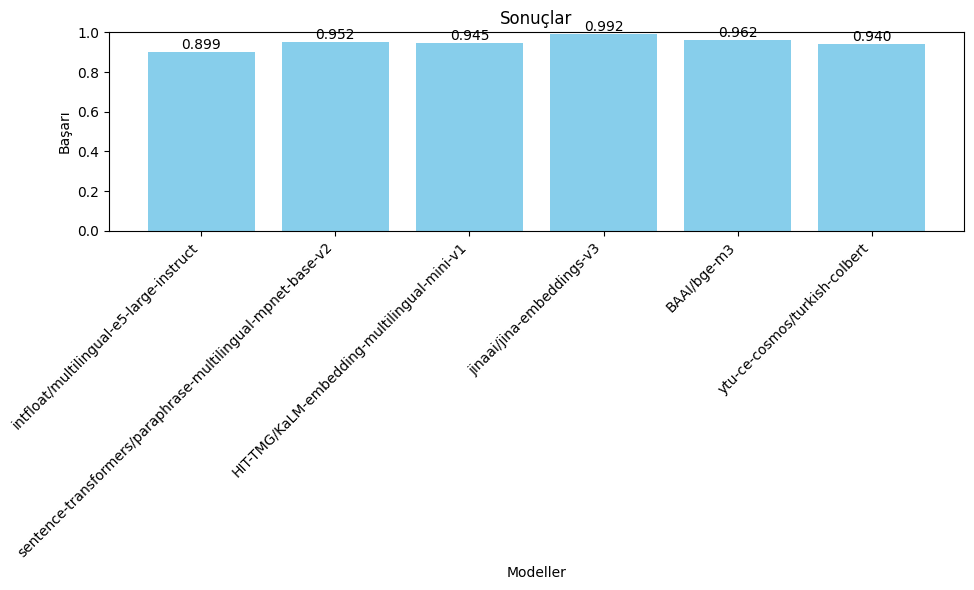

In [11]:
model_top_5_results = {"models": [], "accuracy": []} # Initialize with empty lists
for model_name in all_models:
  embeddings = model_embeddings_list[model_name]
  accuracy = calculate_accuracy(Type.QUESTIONS, embeddings, 5)
  model_top_5_results["models"].append(model_name)
  model_top_5_results["accuracy"].append(accuracy)
  print(f"Model: {model_name}, accuracy: {accuracy}")

draw_results(model_top_5_results)


#### Cevaplar için top-1 sonuçları

Model: intfloat/multilingual-e5-large-instruct, accuracy: 0.872
Model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2, accuracy: 0.895
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1, accuracy: 0.904
Model: jinaai/jina-embeddings-v3, accuracy: 0.971
Model: BAAI/bge-m3, accuracy: 0.933
Model: ytu-ce-cosmos/turkish-colbert, accuracy: 0.84


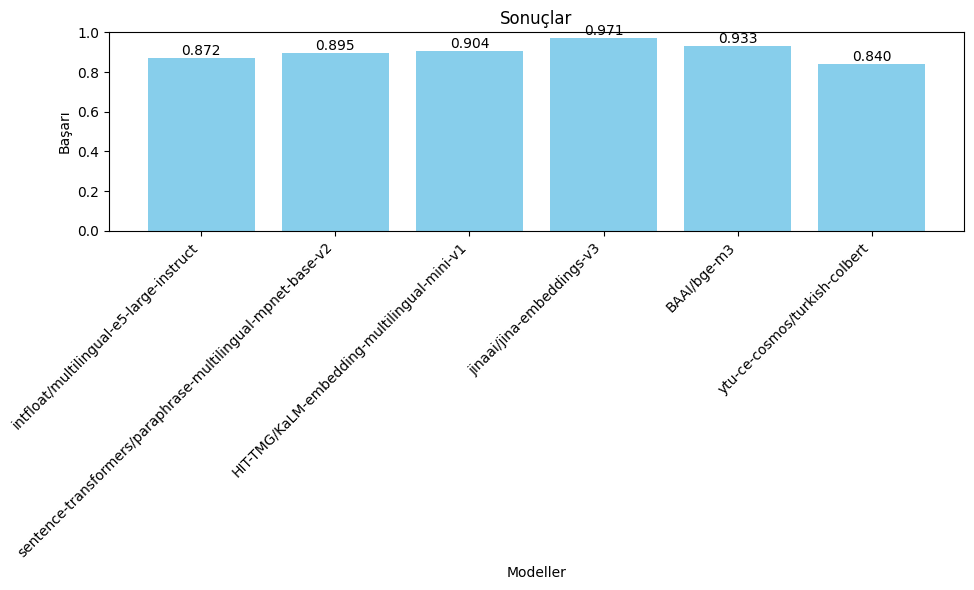

In [12]:
model_top_1_results = {"models": [], "accuracy": []} # Initialize with empty lists

for model_name in all_models:
  embeddings = model_embeddings_list[model_name]
  accuracy = calculate_accuracy(Type.QUESTIONS, embeddings, 1)
  model_top_1_results["models"].append(model_name)
  model_top_1_results["accuracy"].append(accuracy)
  print(f"Model: {model_name}, accuracy: {accuracy}")

draw_results(model_top_1_results)

#### Sorular için top-5 sonuçları

Model: intfloat/multilingual-e5-large-instruct, accuracy: 0.994
Model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2, accuracy: 0.982
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1, accuracy: 0.98
Model: jinaai/jina-embeddings-v3, accuracy: 0.996
Model: BAAI/bge-m3, accuracy: 0.991
Model: ytu-ce-cosmos/turkish-colbert, accuracy: 0.951


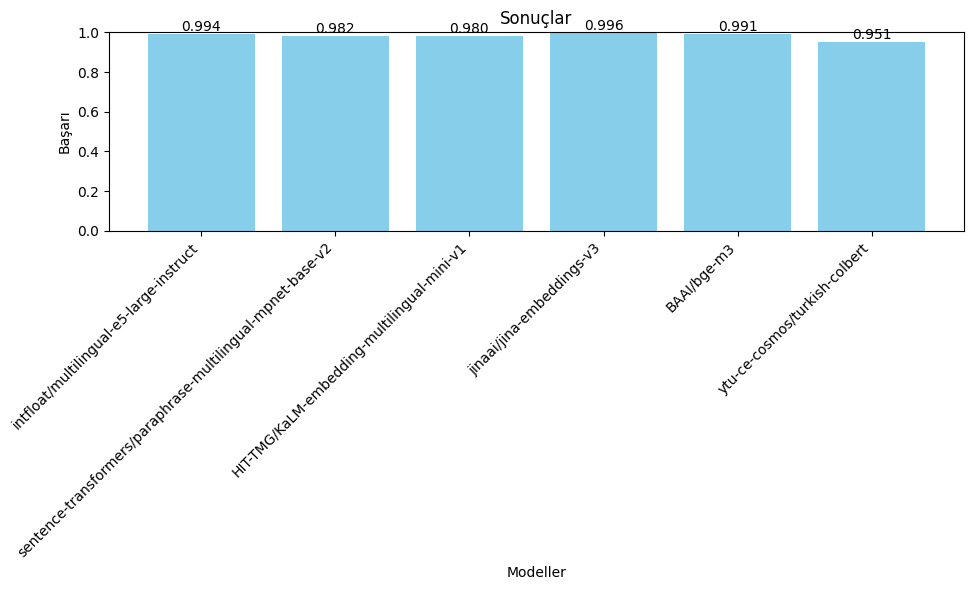

In [16]:
model_top_5_results = {"models": [], "accuracy": []} # Initialize with empty lists

for model_name in all_models:
  embeddings = model_embeddings_list[model_name]
  accuracy = calculate_accuracy(Type.ANSWERS, embeddings, 5)
  model_top_5_results["models"].append(model_name)
  model_top_5_results["accuracy"].append(accuracy)
  print(f"Model: {model_name}, accuracy: {accuracy}")

draw_results(model_top_5_results)


#### Sorular için top-1 sonuçları

Model: intfloat/multilingual-e5-large-instruct, accuracy: 0.976
Model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2, accuracy: 0.936
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1, accuracy: 0.947
Model: jinaai/jina-embeddings-v3, accuracy: 0.978
Model: BAAI/bge-m3, accuracy: 0.966
Model: ytu-ce-cosmos/turkish-colbert, accuracy: 0.852


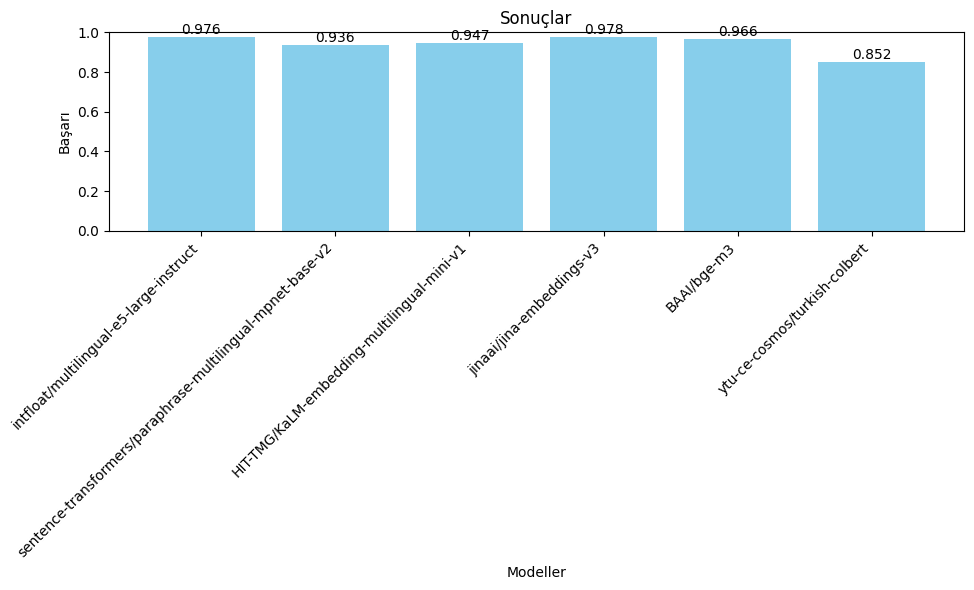

In [17]:
model_top_1_results = {"models": [], "accuracy": []} # Initialize with empty lists

for model_name in all_models:
  embeddings = model_embeddings_list[model_name]
  accuracy = calculate_accuracy(Type.ANSWERS, embeddings, 1)
  model_top_1_results["models"].append(model_name)
  model_top_1_results["accuracy"].append(accuracy)
  print(f"Model: {model_name}, accuracy: {accuracy}")

draw_results(model_top_1_results)


#### tsne gösterimleri

[[-42.12874    -0.120157 ]
 [ 31.651201   53.90251  ]
 [-23.349169  -21.013397 ]
 ...
 [ 61.841698   11.717761 ]
 [ 73.234344   15.820158 ]
 [  5.1062922  -4.0588293]]


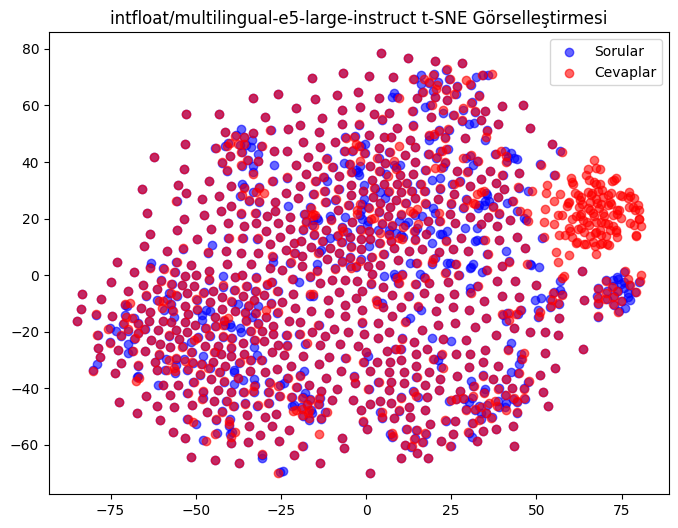

[[-36.715565  -4.559332]
 [ 44.250664  33.701603]
 [ -3.167073  47.052982]
 ...
 [-68.05426    9.251336]
 [-29.032402  50.46219 ]
 [ 13.09642  -14.923196]]


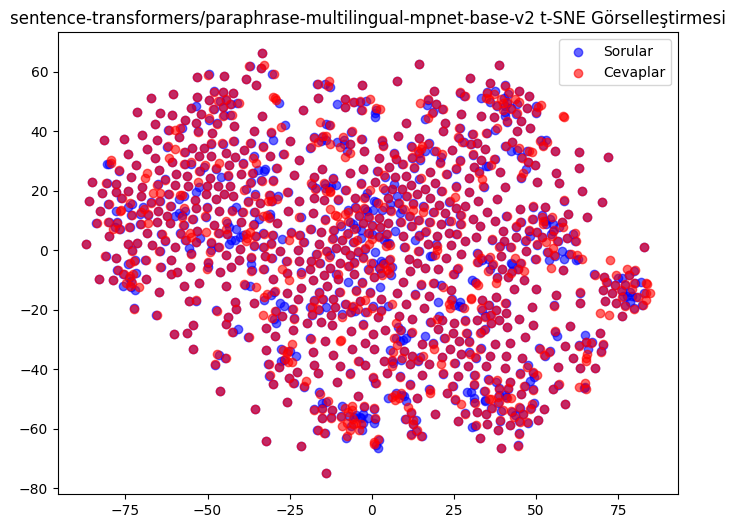

[[ 52.366528   11.300429 ]
 [-44.098385  -12.956615 ]
 [ 38.95186   -46.091145 ]
 ...
 [ 15.408977   27.198717 ]
 [ 22.69266    24.4047   ]
 [-14.518347    1.3691044]]


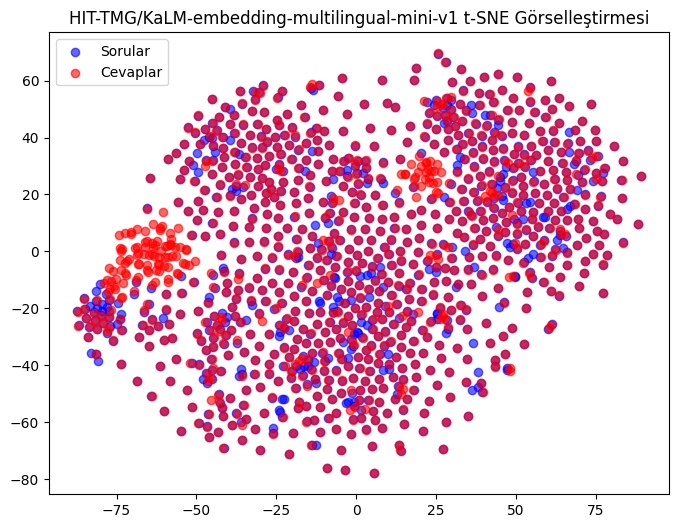

[[ 33.12958   -24.727615 ]
 [-40.054634    6.2751684]
 [ 21.547827   20.108257 ]
 ...
 [ 63.729355   -9.693055 ]
 [ 78.26066    -6.631305 ]
 [-16.626308   15.466953 ]]


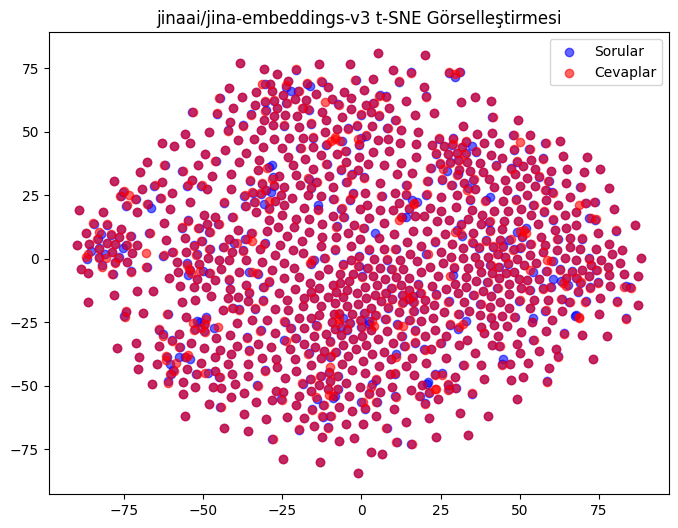

[[-37.10071    -3.6285627]
 [ 24.693354  -26.376669 ]
 [-34.192898   33.741264 ]
 ...
 [-45.610924   38.788425 ]
 [-83.39386   -18.440615 ]
 [ -4.2657905 -49.301853 ]]


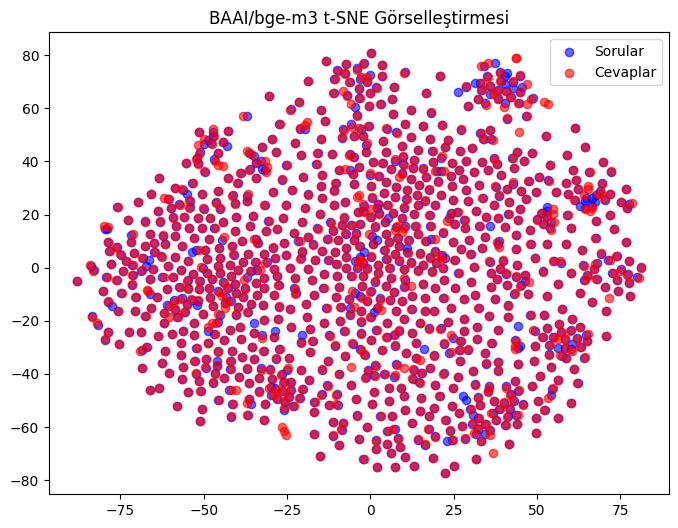

[[-38.424587    13.156725  ]
 [ 22.118029   -15.858168  ]
 [ 15.963422    -0.36364475]
 ...
 [-62.119305    13.492471  ]
 [-55.98969     17.455389  ]
 [-16.84665    -48.99867   ]]


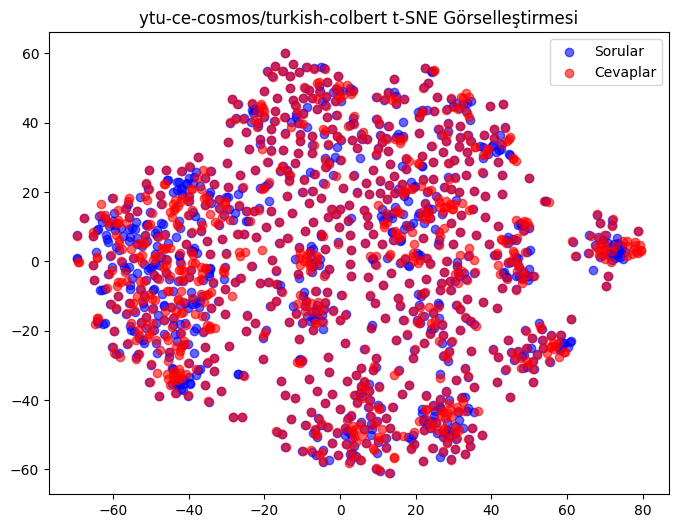

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(model_name, embeddings):
    combined = torch.cat([embeddings[Type.QUESTIONS], embeddings[Type.ANSWERS]])

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(combined.cpu().numpy())
    print(reduced)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:1000, 0], reduced[:1000, 1], c="blue", label="Sorular", alpha=0.6)
    plt.scatter(reduced[1000:, 0], reduced[1000:, 1], c="red", label="Cevaplar", alpha=0.6)
    plt.legend()
    plt.title(f"{model_name} t-SNE Görselleştirmesi")
    plt.show()

# Tüm modeller için görselleştirme yap
for model_name in all_models:
    model_embeddings = model_embeddings_list[model_name]
    plot_tsne(model_name, model_embeddings)
